In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [32]:
# Import necessary libraries

import pandas as pd
import numpy as np
import nltk
import re
import os
import json
import spacy
import nltk
from nltk.util import ngrams
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

In [33]:
# Download necessary NLTK resources for text processing
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [34]:
# Load the Excel file
data_path = '/content/drive/MyDrive/scholarlink_nlp/university_data.xlsx'

# Load the data for students and professors
students_df = pd.read_excel(data_path, sheet_name='Students')
professors_df = pd.read_excel(data_path, sheet_name='Professors')

In [35]:
# Normalize and trim text data to ensure consistency
students_df = students_df.applymap(lambda x: x.strip().lower() if isinstance(x, str) else x)
professors_df = professors_df.applymap(lambda x: x.strip().lower() if isinstance(x, str) else x)

# Handle missing data by filling missing values with 'unknown'
students_df.fillna('unknown', inplace=True)
professors_df.fillna('unknown', inplace=True)

# Convert the 'Research Interests' column into lists for easier manipulation
students_df['Research Interests'] = students_df['Research Interests'].apply(lambda x: x.split(', '))
professors_df['Research Interests'] = professors_df['Research Interests'].apply(lambda x: x.split(', '))


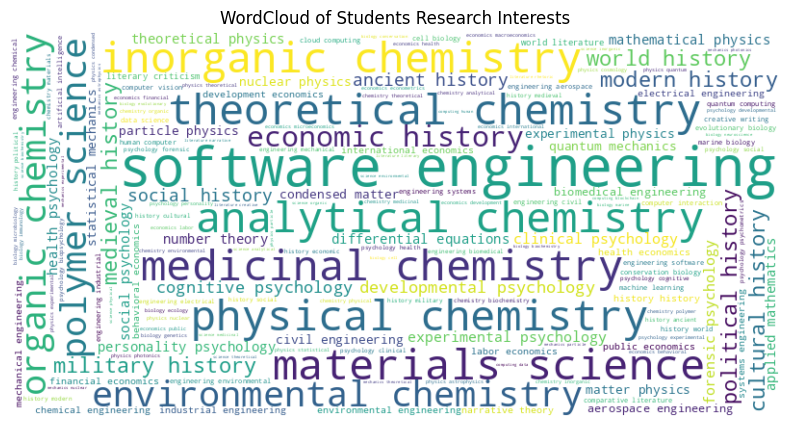

In [36]:
# WordCloud for Students' Research Interests
all_students_interests = ' '.join([interest for sublist in students_df['Research Interests'] for interest in sublist])
wordcloud_students = WordCloud(width = 800, height = 400, background_color ='white').generate(all_students_interests)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_students, interpolation='bilinear')
plt.axis("off")
plt.title('WordCloud of Students Research Interests')
plt.show()

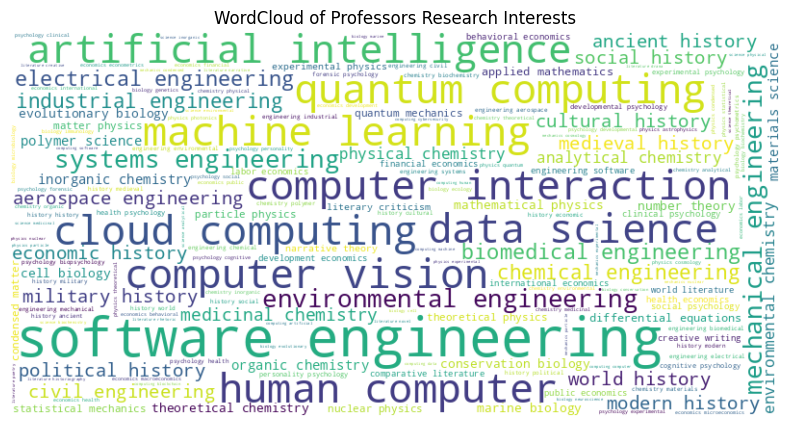

In [37]:
# WordCloud for Professors' Research Interests
all_professors_interests = ' '.join([interest for sublist in professors_df['Research Interests'] for interest in sublist])
wordcloud_professors = WordCloud(width = 800, height = 400, background_color ='white').generate(all_professors_interests)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_professors, interpolation='bilinear')
plt.axis("off")
plt.title('WordCloud of Professors Research Interests')
plt.show()

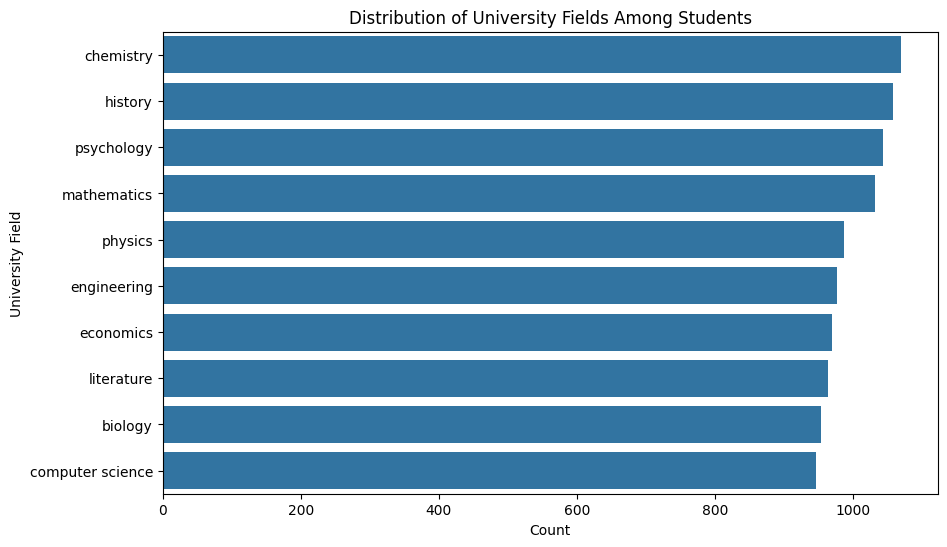

In [38]:
# Distribution of University Field for Students
plt.figure(figsize=(10, 6))
sns.countplot(y=students_df['University Field'], order = students_df['University Field'].value_counts().index)
plt.title('Distribution of University Fields Among Students')
plt.xlabel('Count')
plt.ylabel('University Field')
plt.show()

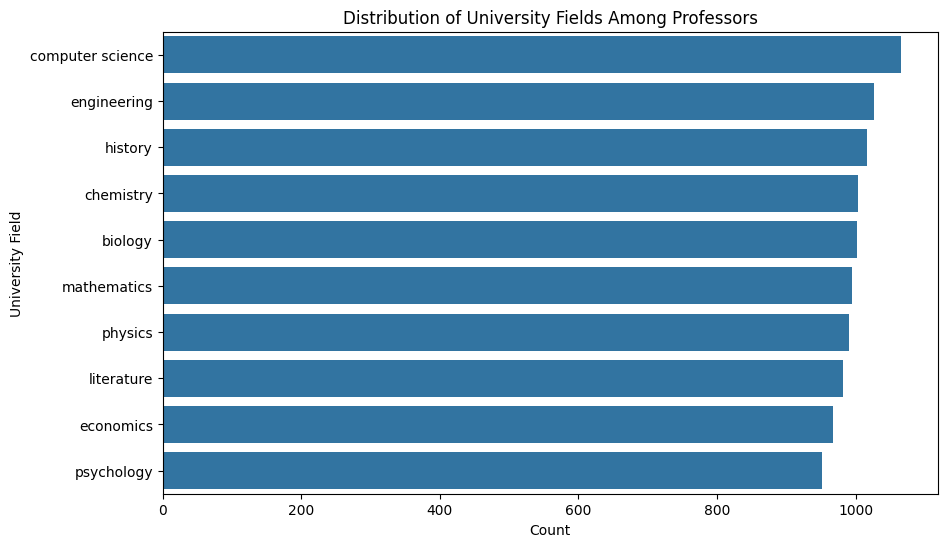

In [39]:
# Distribution of University Field for Professors
plt.figure(figsize=(10, 6))
sns.countplot(y=professors_df['University Field'], order = professors_df['University Field'].value_counts().index)
plt.title('Distribution of University Fields Among Professors')
plt.xlabel('Count')
plt.ylabel('University Field')
plt.show()

In [40]:
# Load SpaCy's English tokenizer
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Update the stop words list with domain-specific terms
domain_specific_stopwords = {'using', 'study', 'research', 'project', 'data'}
STOP_WORDS.update(domain_specific_stopwords)

# Efficient text processing function to process and lemmatize texts in batches
def efficient_text_processing(texts):
    processed_texts = []
    for doc in nlp.pipe(texts, batch_size=50):
        tokens = [token.lemma_ for token in doc
                  if token.is_alpha and not token.is_stop and len(token.lemma_) > 2]
        processed_texts.append(' '.join(tokens))
    return processed_texts

# Prepare and process data for similarity calculations
students_interests = students_df['Research Interests'].apply(lambda x: ', '.join(x)).tolist()
professors_interests = professors_df['Research Interests'].apply(lambda x: ', '.join(x)).tolist()
students_df['Processed Research Interests'] = efficient_text_processing(students_interests)
professors_df['Processed Research Interests'] = efficient_text_processing(professors_interests)

In [41]:
# Load a larger SpaCy model for better accuracy in generating embeddings
nlp = spacy.load('en_core_web_lg')

In [42]:
# One-hot encoding of 'University Field'
encoder = OneHotEncoder()
all_fields = np.concatenate((students_df['University Field'].values, professors_df['University Field'].values), axis=0)
encoder.fit(all_fields.reshape(-1, 1))
student_fields_encoded = encoder.transform(students_df['University Field'].values.reshape(-1, 1)).toarray()
professor_fields_encoded = encoder.transform(professors_df['University Field'].values.reshape(-1, 1)).toarray()

# Generate embeddings for the processed text, average them if there are multiple tokens
def get_embedding(text):
    doc = nlp(text)
    vectors = [token.vector for token in doc if token.has_vector]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(nlp.vocab.vectors_length)

# Apply embedding generation
students_df['Research Embeddings'] = students_df['Processed Research Interests'].apply(get_embedding)
professors_df['Research Embeddings'] = professors_df['Processed Research Interests'].apply(get_embedding)

In [43]:
# Combine and weight embeddings with encoded fields, then scale them
weights = {'research_interests': 0.8, 'university_field': 0.2}
scaler = StandardScaler()

# Scale and weight research embeddings
student_research_scaled = scaler.fit_transform(students_df['Research Embeddings'].tolist()) * weights['research_interests']
professor_research_scaled = scaler.transform(professors_df['Research Embeddings'].tolist()) * weights['research_interests']

# Combine scaled and weighted embeddings with encoded fields
student_combined_features = np.hstack((student_research_scaled, student_fields_encoded * weights['university_field']))
professor_combined_features = np.hstack((professor_research_scaled, professor_fields_encoded * weights['university_field']))


In [44]:
'''combined_features = np.hstack((student_combined_features, professor_combined_features))
sns.heatmap(np.corrcoef(combined_features, rowvar=False), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Heatmap of Feature Correlation')
plt.show()''' #takes time to execute > 10 mins

'combined_features = np.hstack((student_combined_features, professor_combined_features))\nsns.heatmap(np.corrcoef(combined_features, rowvar=False), annot=True, fmt=".2f", cmap=\'coolwarm\')\nplt.title(\'Heatmap of Feature Correlation\')\nplt.show()'

In [46]:
'''def generate_ground_truth(data1, data2, key1, key2, interest_key='Research Interests'):
    # Create a mapping of interests to GUIDs for data2
    interest_map = {}
    for index, row in data2.iterrows():
        for interest in row[interest_key]:
            if interest not in interest_map:
                interest_map[interest] = set()
            interest_map[interest].add(row[key2])

    # Generate ground truth by finding matches based on shared interests
    ground_truth = {}
    for index, row in data1.iterrows():
        matched_guids = set()
        for interest in row[interest_key]:
            if interest in interest_map:
                matched_guids.update(interest_map[interest])
        ground_truth[row[key1]] = matched_guids

    return ground_truth
'''
'''# Generate ground truth for both students and professors using the corrected keys
ground_truth_students = generate_ground_truth(students_df, professors_df, key1='Student GUID', key2='Professor GUID')
ground_truth_professors = generate_ground_truth(professors_df, students_df, key1='Professor GUID', key2='Student GUID')

def save_ground_truth(ground_truth, filepath):
    # Convert sets in the ground truth dictionary to lists for JSON serialization
    serializable_ground_truth = {key: list(value) for key, value in ground_truth.items()}
    with open(filepath, 'w') as file:
        json.dump(serializable_ground_truth, file)

# Call this function after generating the ground truth
save_ground_truth(ground_truth_students, '/content/drive/MyDrive/scholarlink_nlp/ground_truth_students.json')
save_ground_truth(ground_truth_professors, '/content/drive/MyDrive/scholarlink_nlp/ground_truth_professors.json')'''
'''# Function to load ground truth from a JSON file
def load_ground_truth(filepath):
    if os.path.exists(filepath):
        with open(filepath, 'r') as file:
            return json.load(file)
    return None  # Return None if the file doesn't exist

# Load ground truth data if available
ground_truth_students = load_ground_truth('/content/drive/MyDrive/scholarlink_nlp/ground_truth_students.json')
ground_truth_professors = load_ground_truth('/content/drive/MyDrive/scholarlink_nlp/ground_truth_professors.json')

# Generate ground truth only if not already loaded
if ground_truth_students is None or ground_truth_professors is None:
    ground_truth_students = generate_ground_truth(students_df, professors_df, key1='Student GUID', key2='Professor GUID')
    ground_truth_professors = generate_ground_truth(professors_df, students_df, key1='Professor GUID', key2='Student GUID')
    save_ground_truth(ground_truth_students, '/content/drive/MyDrive/scholarlink_nlp/ground_truth_students.json')
    save_ground_truth(ground_truth_professors, '/content/drive/MyDrive/scholarlink_nlp/ground_truth_professors.json')
'''

"# Generate ground truth for both students and professors using the corrected keys\nground_truth_students = generate_ground_truth(students_df, professors_df, key1='Student GUID', key2='Professor GUID')\nground_truth_professors = generate_ground_truth(professors_df, students_df, key1='Professor GUID', key2='Student GUID')\n\ndef save_ground_truth(ground_truth, filepath):\n    # Convert sets in the ground truth dictionary to lists for JSON serialization\n    serializable_ground_truth = {key: list(value) for key, value in ground_truth.items()}\n    with open(filepath, 'w') as file:\n        json.dump(serializable_ground_truth, file)\n\n# Call this function after generating the ground truth\nsave_ground_truth(ground_truth_students, '/content/drive/MyDrive/scholarlink_nlp/ground_truth_students.json')\nsave_ground_truth(ground_truth_professors, '/content/drive/MyDrive/scholarlink_nlp/ground_truth_professors.json')"

In [48]:
# Calculate cosine similarity between student and professor features
similarity_matrix = cosine_similarity(student_combined_features, professor_combined_features)

In [49]:
#Functions to get top k recommendations for students and professors based on similarity
def get_student_recommendations(similarity_matrix, students_df, professors_df, top_k=5):
    recommendations = {}
    for idx, student in enumerate(students_df['Student GUID']):
        top_indices = np.argsort(-similarity_matrix[idx])[:top_k]
        top_professors = professors_df.iloc[top_indices][['Professor GUID', 'Name']].to_dict(orient='records')
        recommendations[student] = top_professors
    return recommendations


def get_professor_recommendations(similarity_matrix, students_df, professors_df, top_k=5):
    recommendations = {}
    for idx, professor in enumerate(professors_df['Professor GUID']): #transpose the similarity matrix to match professors to students
        top_indices = np.argsort(-similarity_matrix[:, idx])[:top_k]
        top_students = students_df.iloc[top_indices][['Student GUID', 'Name']].to_dict(orient='records')
        recommendations[professor] = top_students
    return recommendations

# Get and display recommendations for students and professors
student_recommendations = get_student_recommendations(similarity_matrix, students_df, professors_df)
professor_recommendations = get_professor_recommendations(similarity_matrix, students_df, professors_df)

# Display recommendations for the first student and first professor
print("First Student Recommendations:", student_recommendations[students_df.iloc[0]['Student GUID']])
print("First Professor Recommendations:", professor_recommendations[professors_df.iloc[0]['Professor GUID']])

First Student Recommendations: [{'Professor GUID': '497d3bcf-92f0-421e-882e-7a1f1d7f9b91', 'Name': 'timothy hayes'}, {'Professor GUID': 'a1d1b3a6-4651-411e-bbf6-f0ab3e443b55', 'Name': 'xavier nichols'}, {'Professor GUID': '1a5a5fa5-e668-4f76-8c3e-0837bd734c12', 'Name': 'laura miranda'}, {'Professor GUID': '5384f28f-bf4b-4640-b5da-6fa1bb5ef149', 'Name': 'anne lopez'}, {'Professor GUID': 'f2a1725f-8249-4f5a-9239-4bedd875a088', 'Name': 'carl ryan'}]
First Professor Recommendations: [{'Student GUID': 'b172f135-810d-44b2-b0a9-326132e1ab43', 'Name': 'cassandra rodriguez'}, {'Student GUID': '11fc5d73-9d02-4955-8857-3f7388bc2a87', 'Name': 'tammy oliver'}, {'Student GUID': '2e4cb3bb-4b01-4746-b7cc-2335e3821041', 'Name': 'herbert finley'}, {'Student GUID': '384d9be6-fb88-42f2-85d1-bb81e7f16349', 'Name': 'michael vaughan'}, {'Student GUID': '0f47230a-1d36-43b9-a87b-8c0f2b69f63c', 'Name': 'brandi miranda'}]


In [50]:
'''
def evaluate_recommendations(recommendations, ground_truth, entity='student'):
    hits = 0
    total_recommended = 0
    total_relevant = sum(len(v) for v in ground_truth.values())

    # Iterate over each entry in the recommendations to compare with ground truth
    for guid, recs in recommendations.items():
        # Extract GUIDs from recommendations based on the entity type
        if entity == 'student':
            rec_guids = {rec['Professor GUID'] for rec in recs}
        else:
            rec_guids = {rec['Student GUID'] for rec in recs}

        # Get the set of relevant GUIDs from the ground truth for comparison
        relevant_guids = set(ground_truth.get(guid, []))  # Ensure it is a set

        # Calculate hits (correct recommendations)
        hits += len(rec_guids & relevant_guids)  # Now both are sets
        # Count total recommended items
        total_recommended += len(rec_guids)

    # Calculate precision and recall
    precision = hits / total_recommended if total_recommended > 0 else 0
    recall = hits / total_relevant if total_relevant > 0 else 0
    return precision, recall
# Evaluate student recommendations (assuming student_recommendations have been made)
student_precision, student_recall = evaluate_recommendations(
    student_recommendations,
    ground_truth_students,  # This should be prepared as mentioned
    'student'  # Tells the function to look for 'Professor GUID' in the recommendations
)

# Evaluate professor recommendations (assuming professor_recommendations have been made)
professor_precision, professor_recall = evaluate_recommendations(
    professor_recommendations,
    ground_truth_professors,  # This should be prepared as mentioned
    'professor')  # Tells the function to look for 'Student GUID' in the recommendations
# Print results
print(f"Student Precision: {student_precision}, Student Recall: {student_recall}")
print(f"Professor Precision: {professor_precision}, Professor Recall: {professor_recall}")'''

'\ndef evaluate_recommendations(recommendations, ground_truth, entity=\'student\'):\n    hits = 0\n    total_recommended = 0\n    total_relevant = sum(len(v) for v in ground_truth.values())\n\n    # Iterate over each entry in the recommendations to compare with ground truth\n    for guid, recs in recommendations.items():\n        # Extract GUIDs from recommendations based on the entity type\n        if entity == \'student\':\n            rec_guids = {rec[\'Professor GUID\'] for rec in recs}\n        else:\n            rec_guids = {rec[\'Student GUID\'] for rec in recs}\n        \n        # Get the set of relevant GUIDs from the ground truth for comparison\n        relevant_guids = set(ground_truth.get(guid, []))  # Ensure it is a set\n        \n        # Calculate hits (correct recommendations)\n        hits += len(rec_guids & relevant_guids)  # Now both are sets\n        # Count total recommended items\n        total_recommended += len(rec_guids)\n\n    # Calculate precision and recal